In [1]:
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


VanillaClassifier(
  (net): MLP(
    (layers): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=256, out_features=128, bias=True)
      (9): BatchNorm1d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.01)
      (11): Dropout(p=0.1, inplace=False)
      (12): Linear(in_features=128, out_features=10, bias=True)
      (13): Identity()
    )
  )
)
--- EPOCH 1/500 ---
train_batch (Avg. Loss 0.557, Accuracy 80.6): 100%|█| 547/547 [00:04<00:00, 127.
test_batch (Avg. Lo

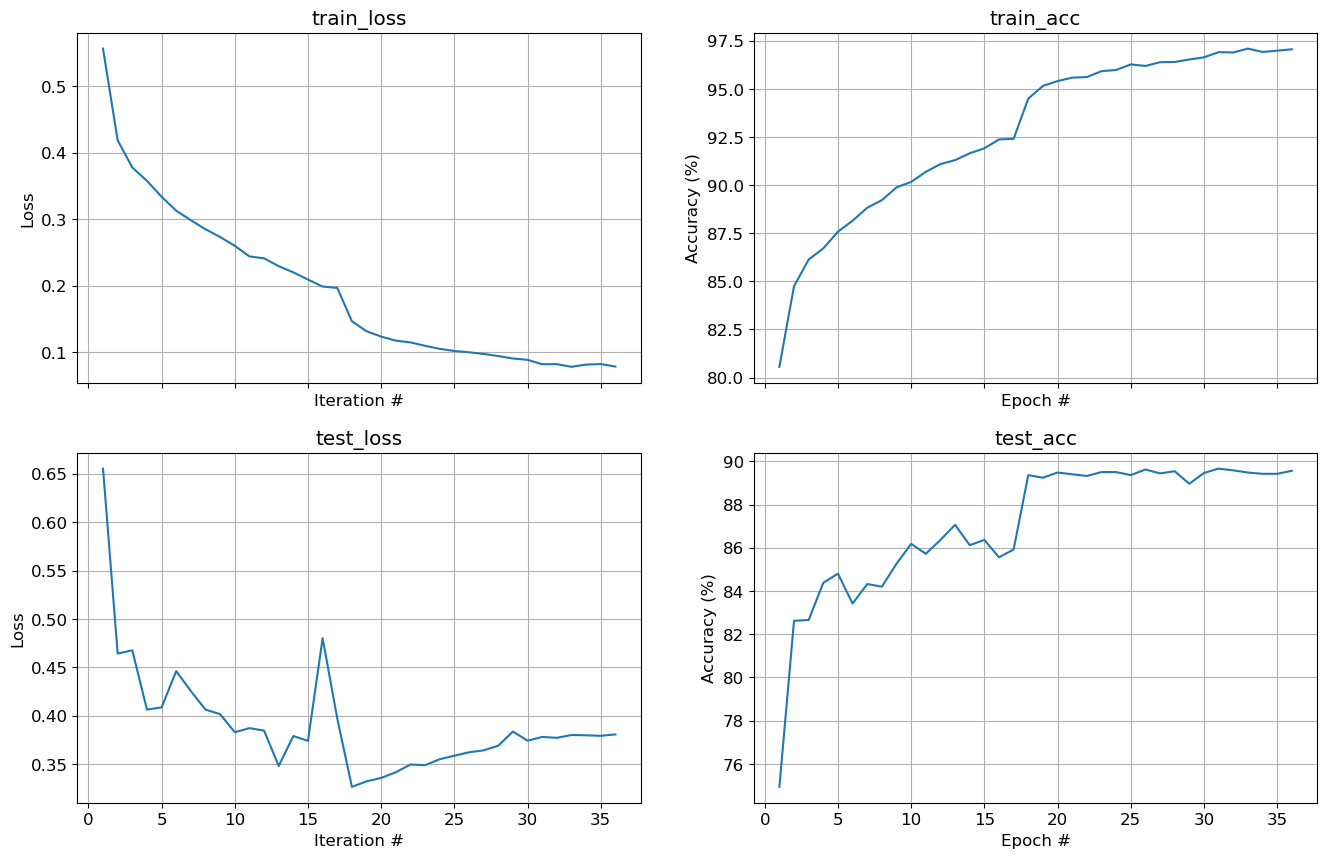

In [5]:
import torch.nn as nn
import torch.optim as optim
from training import ClassifierTrainer
from classifier import VanillaClassifier
from utils import set_random_seeds, vec_to_img, get_fmnist_functa
from plot import plot_fit

data_path = '/datasets/functaset'
num_classes = 10
in_features = 512
checkpoint_file = 'checkpoints/mlp'
num_epochs = 500
early_stopping = 5
lr = 1e-3
hidden_dims = [512, 256, 128]
p_dropout = 0.1
batch_size = 64
normalization = "batch"
activations = ["lrelu"]*len(hidden_dims)


loss_fn = nn.CrossEntropyLoss()
set_random_seeds(0)
train_functaloader = get_fmnist_functa(data_dir=f"{data_path}/fmnist_train.pkl", mode='train',
                                                   batch_size=batch_size, num_workers=2)
val_functaloader = get_fmnist_functa(data_dir=f"{data_path}/fmnist_val.pkl", mode='test',
                                                 batch_size=batch_size, num_workers=2)

model = VanillaClassifier(in_features=in_features, num_classes=num_classes, hidden_dims=hidden_dims,
                                      nonlins=activations, p_dropout=p_dropout,
                                      normalization=normalization).to(device)
print(model)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='max', factor=0.1, patience=3, verbose=True)

def post_epoch_fn(epoch, train_res, test_res, verbose):
    scheduler.step(test_res.accuracy)

trainer = ClassifierTrainer(model, loss_fn, optimizer, device)

# Train, unless final checkpoint is found
checkpoint_file_final = f'{checkpoint_file}_final.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    model.load_state_dict(saved_state['model_state'])
else:
    try:

        fit_res = trainer.fit(train_functaloader, val_functaloader, num_epochs, max_batches=None,
                                  post_epoch_fn=post_epoch_fn, early_stopping=early_stopping,
                                  checkpoints=checkpoint_file_final, print_every=1)
        fig, axes = plot_fit(fit_res)
        print(f"last checkpoint idx: {fit_res.last_checkpoint_idx}")
    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')